In [146]:
import ants
import matplotlib.pyplot as plt
import numpy as np
import glob
from os import listdir

path = "brats/0_t1_corrected.nii.gz"
img = ants.image_read(t1_path)
img = img.numpy()
shape = img.shape
num_patients = 5
modalities = 4

data = np.zeros((shape[2]*num_patients, shape[0], shape[1], modalities))

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

OHE_labels = np.zeros((shape[2]*num_patients, shape[0], shape[1], len(mapping)))

#fixme: should input be one slice och whole image.
# Right now it reads only one slice.
def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

num_slices = shape[2]
for i in range(num_patients):
    print('Patient ' + str(i))
    t1_path = "brats/" + str(i) + "_t1_corrected.nii.gz"
    t1ce_path = "brats/" + str(i) + "_t1ce_corrected.nii.gz"
    t2_path = "brats/" + str(i) + "_t2_corrected.nii.gz"
    flair_path = "brats/" + str(i) + "_flair_corrected.nii.gz"
    gt_path = "brats/" + str(i) + "_seg.nii.gz"

    img_t1 = ants.image_read(t1_path)
    img_t1ce = ants.image_read(t1ce_path)
    img_t2 = ants.image_read(t2_path)
    img_flair = ants.image_read(flair_path)
    img_gt = ants.image_read(gt_path)

    img_t1 = img_t1.numpy()
    img_t1ce = img_t1ce.numpy()
    img_t2 = img_t2.numpy()
    img_flair = img_flair.numpy()
    img_gt = img_gt.numpy()
    
    #print("picture shape:" + str(img_t1.shape))
    #print("moved axis shape:" + str(np.moveaxis(img_t1, -1, 0).shape))
    #print("data shape:" + str(data[(i*shape[2]):((i+1)*shape[2]), :, :, 0].shape))
    
    # The last axis will become the first axis
    data[(i*num_slices):((i+1)*num_slices), :, :, 0] = np.moveaxis(img_t1, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 1] = np.moveaxis(img_t1ce, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 2] = np.moveaxis(img_t2, -1, 0)
    data[(i*num_slices):((i+1)*num_slices), :, :, 3] = np.moveaxis(img_flair, -1, 0)
    
    for j in range(num_slices):
        OHE_labels[i*num_slices+j, :, :, :] = OHE(img_gt[:, :, j], mapping)



Patient 0
Patient 1
Patient 2
Patient 3
Patient 4


(775, 240, 240, 4)


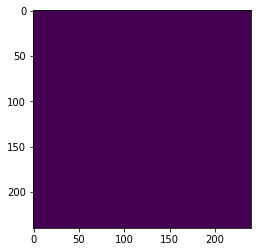

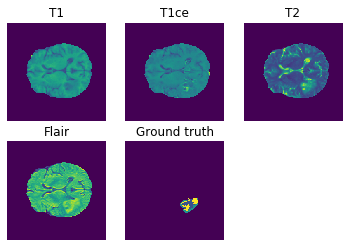

In [151]:
# This will show a slice of the last patient
ind = 70
plt.subplot('231')
plt.title("T1")
plt.imshow(img_t1[:, :, ind])
plt.axis('off')
plt.subplot('232')
plt.title("T1ce")
plt.imshow(img_t1ce[:, :, ind])
plt.axis('off')
plt.subplot('233')
plt.title("T2")
plt.imshow(img_t2[:, :, ind])
plt.axis('off')
plt.subplot('234')
plt.title("Flair")
plt.imshow(img_flair[:, :, ind])
plt.axis('off')
plt.subplot('235')
plt.title("Ground truth")
plt.imshow(img_gt[:, :, ind])
plt.axis('off')
plt.show()

(-0.5, 239.5, 239.5, -0.5)

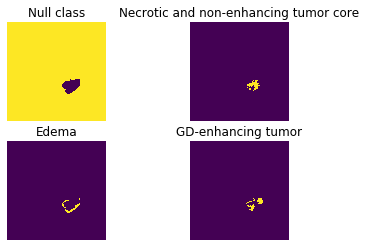

In [152]:
# Visualise one hot encoding
my_OHE = OHE(img_gt[:, :, ind], mapping)
plt.subplot('221')
plt.title(mapping.get(0))
plt.imshow(my_OHE[:,:,0])
plt.axis('off')
plt.subplot('222')
plt.title(mapping.get(1))
plt.imshow(my_OHE[:,:,1])
plt.axis('off')
plt.subplot('223')
plt.title(mapping.get(2))
plt.imshow(my_OHE[:,:,2])
plt.axis('off')
plt.subplot('224')
plt.title(mapping.get(4))
plt.imshow(my_OHE[:,:,3])
plt.axis('off')


In [153]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  # Not sure what the three lines below are doing
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Activation('softmax')(permute)
  # Den här raden kod är ju om man vill få outputlagret till den form man önskar men det är nog smartare att reshapea labelsen
  #reshape = Reshape((num_classes, input_size[0], input_size[1]), input_shape = (num_classes, input_size[0]*input_size[1]))(activation)
  
  model = Model(input = inputs, output = activation)
  model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

In [154]:
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
my_unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 240, 240, 64) 2368        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 240, 240, 64) 36928       conv2d_163[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 120, 120, 64) 0           conv2d_164[0][0]                 
____________________________________________________________________________________________

/Users/linuslagergren/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [165]:
# Train model
samples_used = 200
train_data = data[0:samples_used, :, :, :]
train_labels = OHE_labels[0:samples_used, :, :, :]

# You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
train_labels = train_labels.reshape(samples_used,-1,4)

# Returns an object with accuracy and loss
history = my_unet.fit(x=train_data, y=train_labels, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)


Epoch 1/1
200/200 [==============================] - 688s 3s/step - loss: 1.3863 - acc: 0.9945


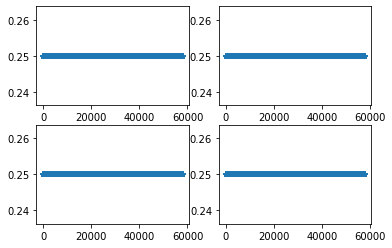

In [207]:
# Make a prediction on a sample m
m = 401
x = data[m, :, :, :].reshape(1, 240, 240, 4)
y = OHE_labels[m, :, :, :]
y = y.reshape(1, -1, 4)

yhat = my_unet.predict(x = x)
#yhat = yhat.reshape(240, 240, 4)
#plt.plot(np.arange(len(yhat[:,:,0])), yhat[:,:,0])
yhat = yhat.reshape([57600, 4])
x = np.arange(len(yhat[:,0]))


plt.subplot('221')
#plt.imshow(yhat[:,:,0])
plt.plot(x, yhat[:,0], '*')
plt.subplot('222')
#plt.imshow(yhat[:,:,1])
plt.plot(x, yhat[:,1], '*')
plt.subplot('223')
#plt.imshow(yhat[:,:,2])
plt.plot(x, yhat[:,2], '*')
plt.subplot('224')
#plt.imshow(yhat[:,:,3])
plt.plot(x, yhat[:,3], '*')


In [183]:
# Test on 100 samples which the network was not trained on
test_data = data[samples_used:(samples_used+100), :, :, :]
test_labels = OHE_labels[samples_used:(samples_used+100), :, :, :]
test_labels = test_labels.reshape(100, -1,4)
print(my_unet.evaluate(x = test_data, y=test_labels))


100/100 [==============================] - 93s 928ms/step
[1.3863025903701782, 0.9773831558227539]


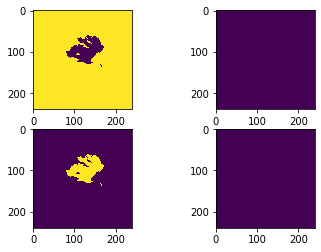

In [158]:
plt.subplot('221')
plt.imshow(ground_truth[:,:,0])
plt.subplot('222')
plt.imshow(ground_truth[:,:,1])
plt.subplot('223')
plt.imshow(ground_truth[:,:,2])
plt.subplot('224')
plt.imshow(ground_truth[:,:,3])